In [1]:
here::i_am("rna_atac/differential/RNA.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(edgeR))


BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 21

# Multi core using future - built in to seurat
plan("multicore", workers = 16)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code

Warning message:
“package ‘rtracklayer’ was built under R version 4.2.3”


In [12]:
args = list()

# Metadata
args$metadata = file.path(io$basedir, 'results/rna_atac/clustering/metadata_celltype_annotated_v2.txt.gz')

# RNA_sce
args$rna_sce = file.path(io$basedir, 'processed/rna/SingleCellExperiment.rds')

# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/abundance/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

In [52]:
# Load meta
meta = fread(args$metadata)

#### Load Data

In [4]:
# Prepare mofa umap
umap.dt = meta[,c('cell', 'UMAP1', 'UMAP2', 'genotype')]

In [5]:
celltype_proportions = meta %>% copy() %>%
    .[,Ntot := .N, by = c('day', 'genotype')] %>%
    .[,proportion := .N/Ntot, by = c('day', 'genotype', 'celltype_v2')] %>% 
    unique(by = c('day', 'genotype', 'celltype_v2')) %>% 
    .[,day := factor(day, levels = rev(names(opts$days.colors)))] %>% 
    .[, c('day', 'genotype', 'celltype_v2', 'proportion')]

all = expand.grid(unique(celltype_proportions$day), unique(celltype_proportions$genotype), unique(celltype_proportions$celltype_v2)) %>%
    setnames(c('day', 'genotype', 'celltype_v2'))

celltype_proportions = merge(celltype_proportions, all, by = c('day', 'genotype', 'celltype_v2'), all=TRUE) %>% 
    .[,proportion:= ifelse(is.na(proportion), 0, proportion)] %>%
    .[,proportion:= ifelse(genotype=='KO' & day == 'D3', .[genotype=='WT' & day == 'D3', proportion], proportion)] %>% 
    .[,genotype:=gsub('KO', 'Eomes KD', genotype)] %>%
    .[,genotype:=factor(genotype, levels=c('WT', 'Eomes KD'))]

celltype_proportions$celltype_v2_figure = opts$celltype_v2_figure[match(celltype_proportions$celltype_v2, names(opts$celltype_v2_figure))]


celltype_proportions = celltype_proportions %>%
    .[,celltype_v2_figure := factor(celltype_v2_figure, levels = rev(c('Primitive Streak', 'Early-Mes #2', 
                                                     'HE Precursor','Blood Progenitor', 'HE','Endothelium', 'Early-Mes #1',
                                                     'Allantois','Allantois Precursor','Posterior Mes', 'Mesenchyme', 'PGC'
                                                     )))] 

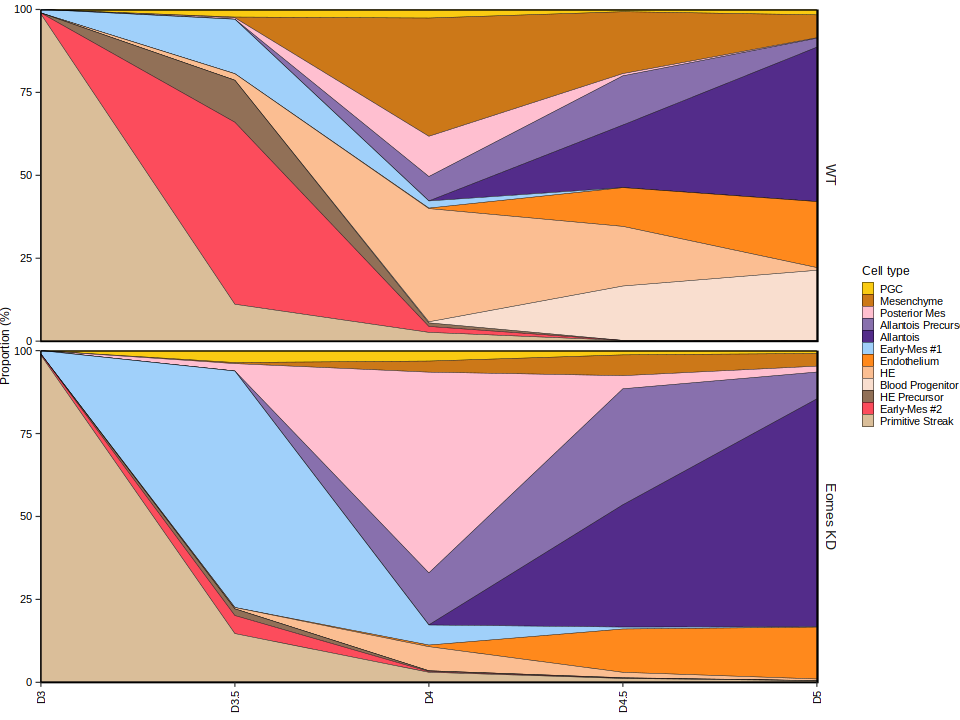

In [6]:
options(repr.plot.width=8, repr.plot.height=6)
p = ggplot(celltype_proportions, aes(day, proportion*100, group=celltype_v2_figure, fill=celltype_v2_figure)) + 
    geom_area(color='black', linewidth=0.1) + 
    scale_fill_manual(values=opts$celltype_v2.colors2, 
                      name = 'Cell type') + 
    guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.5)) +  # Adjust the size of the legend boxes
    facet_wrap(~genotype, ncol=1, strip.position = 'right') +
    ylab('Proportion (%)') +
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    theme_bw() + 
    theme(
        strip.background = element_blank(),
        strip.text = element_text(size=8),
        axis.title = element_text(size = 7),
        axis.text = element_text(size=6, color='black'),
        axis.text.x=element_text(angle=90,hjust=1,vjust=0.5, size=6, color = 'black'), 
        axis.text.y=element_text(hjust=1, size = 6, color = 'black'),
        axis.title.x = element_blank(),
        legend.text = element_text(size=6, color='black'),
        legend.title = element_text(size=7),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        axis.line = element_blank(),
        axis.ticks=element_line(linewidth=0.25),
        panel.spacing = unit(2, 'mm'),
        plot.margin = unit(c(2, 0, 2, 0), "mm"),
        legend.margin = margin(0, 0, 0, 0),  # Adjust the margin inside the legend box
        legend.box.margin = margin(0, 0, 0, 0),  # Adjust the margin outside the legend box
        legend.key = element_blank(),
        legend.justification = "left"  # Align legend to the left
    )

p

In [7]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance.pdf'), 
       plot = p + theme(legend.position = 'none'),
       width = 45, 
       height = 50, 
       units = "mm")

ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance_legend.pdf'), 
       plot = as_ggplot(get_legend(p)),
       width = 25, 
       height = 40, 
       units = "mm")

### Differential Abundance testing

In [53]:
# Remove D3
meta = meta[day != 'D3']

# Prepare mofa umap
umap.mtx = meta[,c('cell', 'UMAP1', 'UMAP2')] %>% 
    as.data.frame(.) %>% 
    tibble::column_to_rownames('cell') %>%
    as.matrix()

#Get MOFA factors
mofa = fread(file.path(io$basedir, 'results/rna_atac/dimensionality_reduction/mofa/MOFA_factors.txt.gz')) %>% 
    .[match(meta$cell, cell),] %>% 
    as.data.frame() %>% tibble::column_to_rownames('cell') %>% 
    as.matrix

In [9]:
neighbors = BiocNeighbors::findKNN(mofa, 100, BPPARAM = BPPARAM)

In [10]:
day_props = meta %>% copy() %>%
    .[,Ntot := .N, by = c('day', 'genotype')] %>% 
    .[,c('day', 'genotype', 'Ntot')] %>% 
    dcast(day~genotype, value.var = 'Ntot') %>% 
    .[,ratio := KO/(KO+WT)]

id_gt = meta %>% copy() %>% 
    .[,c('genotype', 'day')] %>% 
    .[,cell:=.I]

pseudocount = 1
 
DA = mclapply(1:nrow(meta), function(x){ # nrow(meta)
    print(x)
    tmp = data.table(cell = as.vector(neighbors$index[x,])) %>% 
        merge(., id_gt, by = 'cell')
    
    tmp1 = tmp %>% copy() %>% .[,N := .N, by = 'day'] %>% unique(by = 'day') %>% 
        merge(., day_props[,c('day', 'ratio')], by = 'day') %>% 
        .[, N_ratio := ratio * N]
    
    global_ratio = sum(tmp1$N_ratio)/sum(tmp1$N)

    pvalue = binom.test(nrow(tmp[genotype == 'KO']), nrow(tmp), p = global_ratio,
           alternative = "two.sided",
           conf.level = 0.95)$p.value

    tmp2 = data.table(cell = x,
                     # ratio = log2((nrow(tmp[genotype == 'KO']) + pseudocount) / (nrow(tmp[genotype == 'WT']) + pseudocount)),
                      ratio = nrow(tmp[genotype == 'KO']) / (nrow(tmp[genotype == 'KO']) + nrow(tmp[genotype == 'WT'])),
                      global_ratio = global_ratio,
                      pvalue = pvalue)
}, mc.cores = 16) %>% rbindlist() %>% 
    cbind(., meta[,c('UMAP1', 'UMAP2', 'celltype_v2')])

Aggregate function missing, defaulting to 'length'



In [11]:
# DA = DA[,ratio_of_ratios := log2(ratio+1e-1/global_ratio+1e-1)] # Add logFC ratio of ratios
DA = DA[,ratio_m_global := ratio - global_ratio] # add ratio - expected ratio
DA = DA[,padj := p.adjust(pvalue, method = 'fdr')] %>% 
    .[,mlog10padj := -log10(padj)] %>% # add -log10(padj)
    .[,mlog10padj := ifelse(ratio_m_global < 0, mlog10padj*-1, mlog10padj)] # make signed based on sign of changes

In [13]:
fwrite(DA, file.path(args$outdir, 'differential_abundance.txt.gz'))

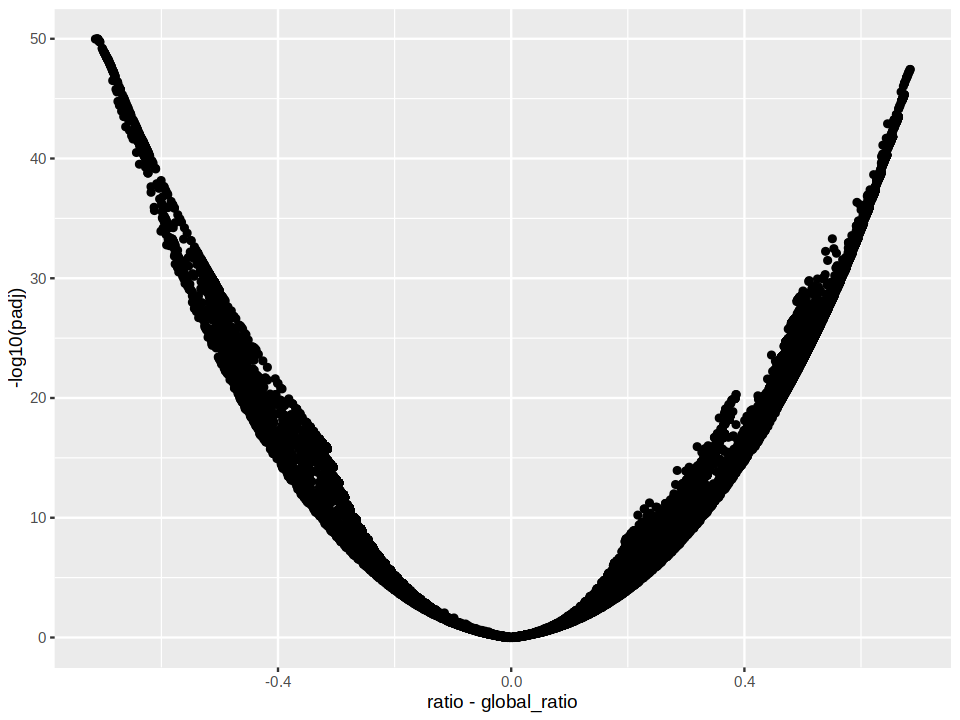

In [14]:
ggplot(DA, aes(ratio-global_ratio, -log10(padj))) + geom_point()

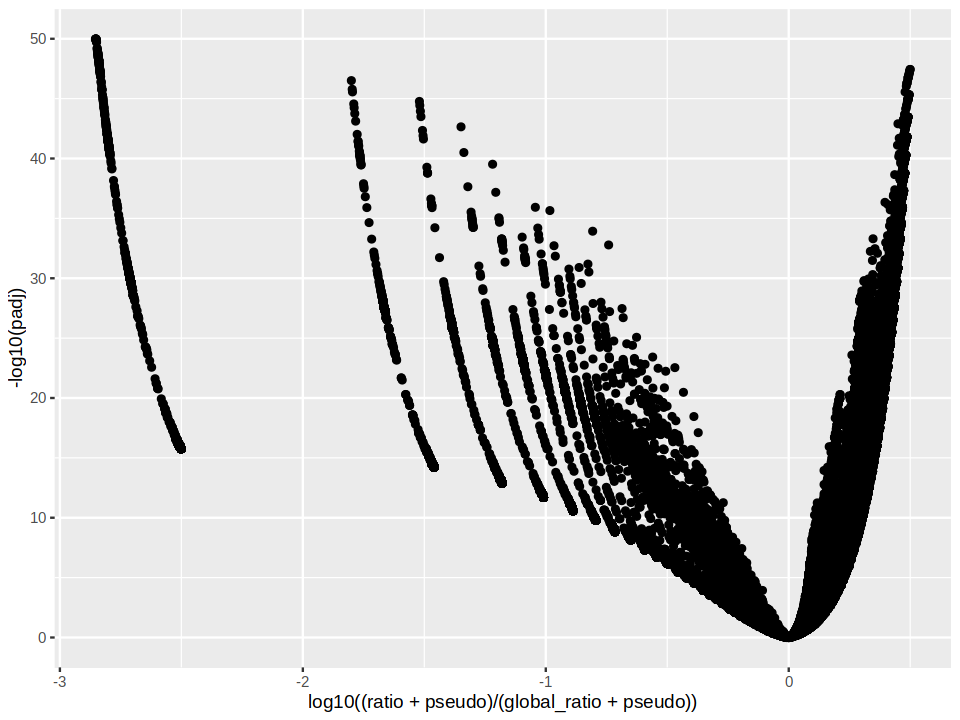

In [15]:
pseudo = 1e-3
ggplot(DA, aes(log10((ratio+pseudo)/(global_ratio+pseudo)), -log10(padj))) + geom_point()

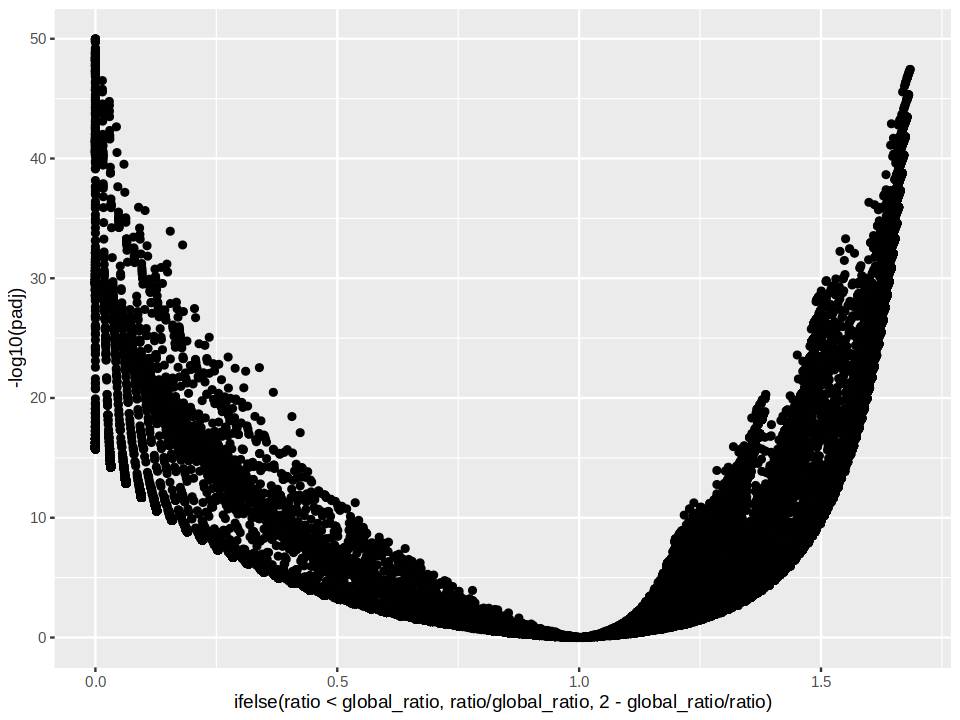

In [16]:
ggplot(DA, aes(ifelse(ratio < global_ratio, ratio/global_ratio, 2-global_ratio/ratio), -log10(padj))) + geom_point()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


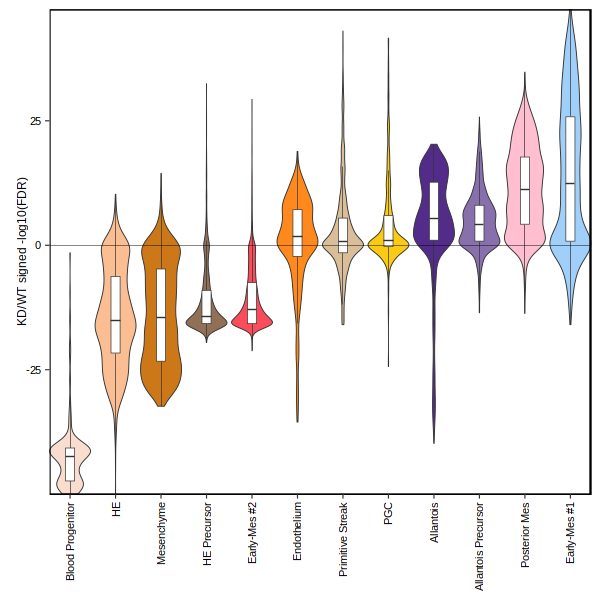

In [17]:
options(repr.plot.width=5, repr.plot.height=5)
DA$celltype_v2_figure = opts$celltype_v2_figure[match(DA$celltype_v2, names(opts$celltype_v2_figure))]
tmp = DA %>% copy() %>% .[,mean := mean(mlog10padj), by = 'celltype_v2_figure'] %>% .[order(mean)] %>% unique(by = 'celltype_v2_figure')
DA = DA[,celltype_v2_figure := factor(celltype_v2_figure, levels = tmp$celltype_v2_figure)]

p2 = ggplot(DA, aes(celltype_v2_figure, mlog10padj, fill=celltype_v2_figure)) + 
    geom_violin(scale = "width", size = 0.2) + 
    geom_boxplot(width=0.2, fill='white', linewidth = 0.15, outlier.shape=NA) +
    geom_hline(yintercept = 0, linewidth = 0.1) + 
    scale_fill_manual(values=opts$celltype_v2.colors2) + 
    ylab('KD/WT signed -log10(FDR)') +
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    theme_bw() + 
    theme(
        axis.text.x=element_text(angle=90,hjust=1,vjust=0.5, size=6, color = 'black'), 
        axis.text.y=element_text(hjust=1, size = 6, color = 'black'),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 7, vjust = -1.5),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.line = element_blank(),
        axis.ticks=element_line(linewidth=0.25),
        legend.position = 'none'
    )
p2

In [18]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance_violins_mlog10padj.pdf'), 
       plot = p2,
       width = 45, 
       height = 50, 
       units = "mm")

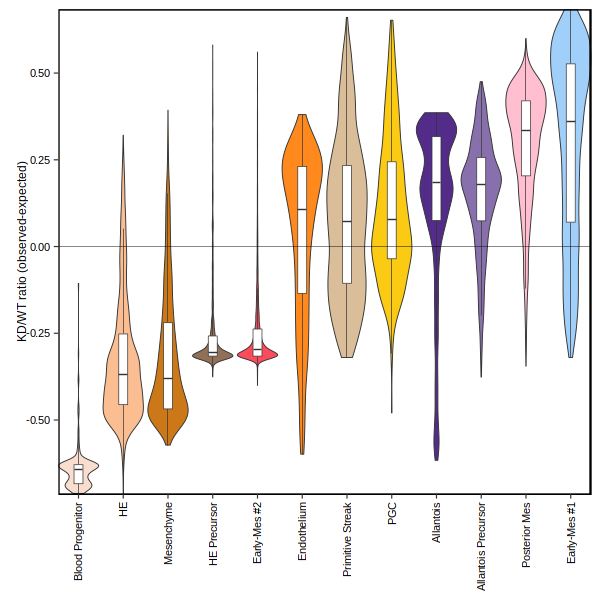

In [19]:
options(repr.plot.width=5, repr.plot.height=5)
DA$celltype_v2_figure = opts$celltype_v2_figure[match(DA$celltype_v2, names(opts$celltype_v2_figure))]
tmp = DA %>% copy() %>% .[,mean := mean(mlog10padj), by = 'celltype_v2_figure'] %>% .[order(mean)] %>% unique(by = 'celltype_v2_figure')
DA = DA[,celltype_v2_figure := factor(celltype_v2_figure, levels = tmp$celltype_v2_figure)]

p2 = ggplot(DA, aes(celltype_v2_figure, ratio-global_ratio, fill=celltype_v2_figure)) + 
    geom_violin(scale = "width", size = 0.2) + 
    geom_boxplot(width=0.2, fill='white', linewidth = 0.15, outlier.shape=NA) +
    geom_hline(yintercept = 0, linewidth = 0.1) + 
    scale_fill_manual(values=opts$celltype_v2.colors2) + 
    ylab('KD/WT ratio (observed-expected)') +
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0), breaks = c(-0.5, -0.25, 0, 0.25, 0.5)) +
    theme_bw() + 
    theme(
        axis.text.x=element_text(angle=90,hjust=1,vjust=0.5, size=6, color = 'black'), 
        axis.text.y=element_text(hjust=1, size = 6, color = 'black'),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 7, vjust = -1.5),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.line = element_blank(),
        axis.ticks=element_line(linewidth=0.25),
        legend.position = 'none'
    )
p2

In [20]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance_violins_ratiomglobalratio.pdf'), 
       plot = p2,
       width = 45, 
       height = 50, 
       units = "mm")

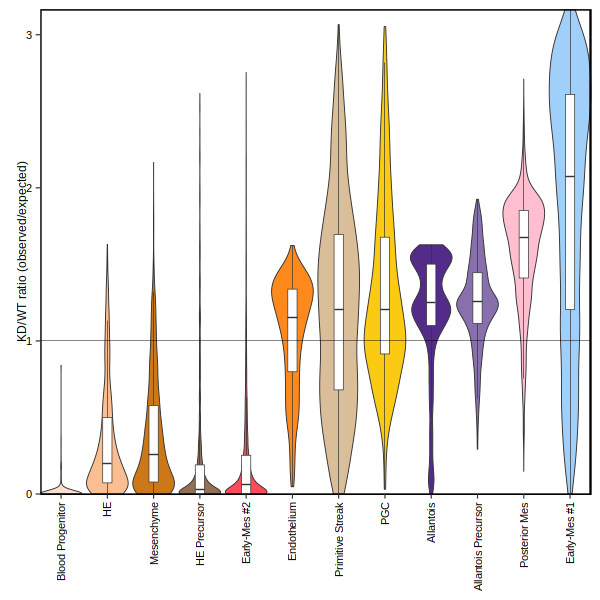

In [21]:
options(repr.plot.width=5, repr.plot.height=5)
DA$celltype_v2_figure = opts$celltype_v2_figure[match(DA$celltype_v2, names(opts$celltype_v2_figure))]
tmp = DA %>% copy() %>% .[,mean := mean(mlog10padj), by = 'celltype_v2_figure'] %>% .[order(mean)] %>% unique(by = 'celltype_v2_figure')
DA = DA[,celltype_v2_figure := factor(celltype_v2_figure, levels = tmp$celltype_v2_figure)]

p2 = ggplot(DA, aes(celltype_v2_figure, ratio/global_ratio, fill=celltype_v2_figure)) + 
    geom_violin(scale = "width", size = 0.2) + 
    geom_boxplot(width=0.2, fill='white', linewidth = 0.15, outlier.shape=NA) +
    geom_hline(yintercept = 1, linewidth = 0.1) + 
    scale_fill_manual(values=opts$celltype_v2.colors2) + 
    ylab('KD/WT ratio (observed/expected)') +
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0), breaks = c(seq(0,10, 1))) +
    theme_bw() + 
    theme(
        axis.text.x=element_text(angle=90,hjust=1,vjust=0.5, size=6, color = 'black'), 
        axis.text.y=element_text(hjust=1, size = 6, color = 'black'),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 7, vjust = -1.5),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.line = element_blank(),
        axis.ticks=element_line(linewidth=0.25),
        legend.position = 'none'
    )
p2

In [22]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance_violins_ratiodglobalratio.pdf'), 
       plot = p2,
       width = 45, 
       height = 50, 
       units = "mm")

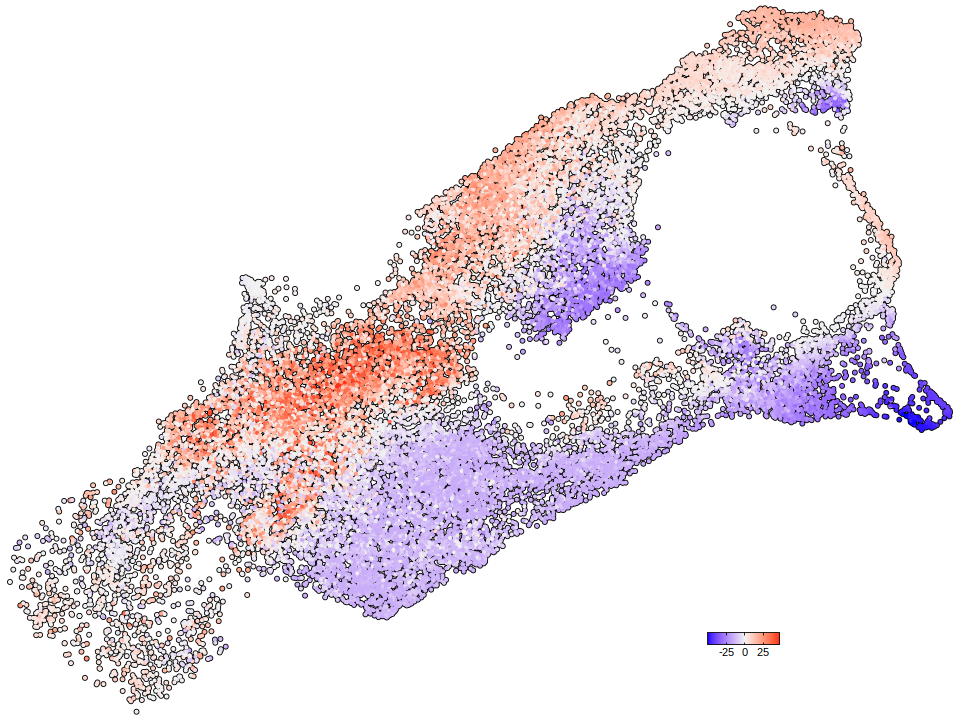

In [23]:
options(repr.plot.width=8, repr.plot.height=6)

DA = DA[order(abs(mlog10padj))]
p3 = ggplot(DA[sample(nrow(DA))], aes(UMAP1, UMAP2, color= mlog10padj)) + 
    geom_point(data = DA, color = 'black', size = 0.6) + 
    geom_point(size = 0.1) + 
    coord_fixed() + 
    scale_color_gradient2(low='blue', mid='grey95', high='red', name='ratio', midpoint = 0) +
    guides(colour = guide_colourbar(
        barwidth = 3, barheight = 0.5,
        frame.colour = "black",
        ticks.colour = 'black')
    ) + 
    scale_x_continuous(expand=c(0.01,0.01)) + 
    scale_y_continuous(expand=c(0.01,0.01)) + 
    theme_void() + 
    theme(legend.position = c(0.77,0.10),
          legend.title = element_blank(), #element_text(vjust = 1, size = 25),
          legend.text = element_text(vjust = 4, size = 6),
          legend.direction = 'horizontal',
          legend.key = element_rect(fill = 'black', colour = "black"))
p3

In [24]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance_umap_mlog10padj.pdf'), 
       plot = p3,
       width = 55, 
       height = 55, 
       units = "mm")

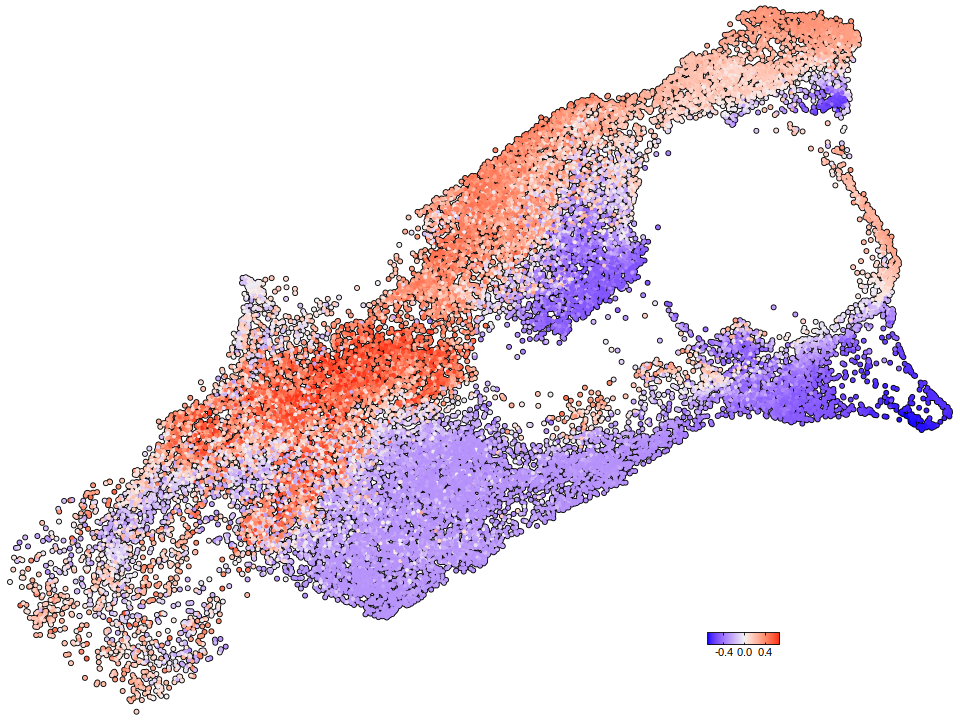

In [25]:
# DA = DA[order(abs(mlog10padj))]
p3 = ggplot(DA[sample(nrow(DA))], aes(UMAP1, UMAP2, color= ratio-global_ratio)) + 
    geom_point(data = DA, color = 'black', size = 0.6) + 
    geom_point(size = 0.1) + 
    coord_fixed() + 
    scale_color_gradient2(low='blue', mid='grey95', high='red', name='ratio', midpoint = 0) +
    guides(colour = guide_colourbar(
        barwidth = 3, barheight = 0.5,
        frame.colour = "black",
        ticks.colour = 'black')
    ) + 
    scale_x_continuous(expand=c(0.01,0.01)) + 
    scale_y_continuous(expand=c(0.01,0.01)) + 
    theme_void() + 
    theme(legend.position = c(0.77,0.10),
          legend.title = element_blank(), #element_text(vjust = 1, size = 25),
          legend.text = element_text(vjust = 4, size = 6),
          legend.direction = 'horizontal',
          legend.key = element_rect(fill = 'black', colour = "black"))
p3

In [26]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance_umap_ratiomglobalratio.pdf'), 
       plot = p3,
       width = 55, 
       height = 55, 
       units = "mm")

In [54]:
#DA = DA[order(abs(mlog10padj))]
p3 = ggplot(DA[sample(nrow(DA))], aes(UMAP1, UMAP2, color= ratio/global_ratio)) + 
    #ggrastr::rasterise(geom_point(data = DA, color = 'black', size = -0.2), dpi = 600) + 
    geom_point(size = -0.3) + 
    coord_fixed() + 
    # scale_color_gradient2(low='blue', mid='grey95', high='red', name='ratio', midpoint = 1) +
    scale_color_gradientn(colors = c('blue', 'grey95', 'red'), values = c(0, 1/max(DA$ratio/DA$global_ratio), 1)) + 
    guides(colour = guide_colourbar(
        barwidth = 3, barheight = 0.5,
        frame.colour = "black",
        ticks.colour = 'black')
    ) + 
    scale_x_continuous(expand=c(0.01,0.01)) + 
    scale_y_continuous(expand=c(0.01,0.01)) + 
    theme_void() + 
    theme(legend.position = c(0.77,0.10),
          legend.title = element_blank(), #element_text(vjust = 1, size = 25),
          legend.text = element_text(vjust = 4, size = 6),
          legend.direction = 'horizontal',
          legend.key = element_rect(fill = 'black', colour = "black"))
# p3

In [48]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance_umap_ratiodglobalratio.pdf'), 
       plot = p3,
       width = 55, 
       height = 55, 
       units = "mm")

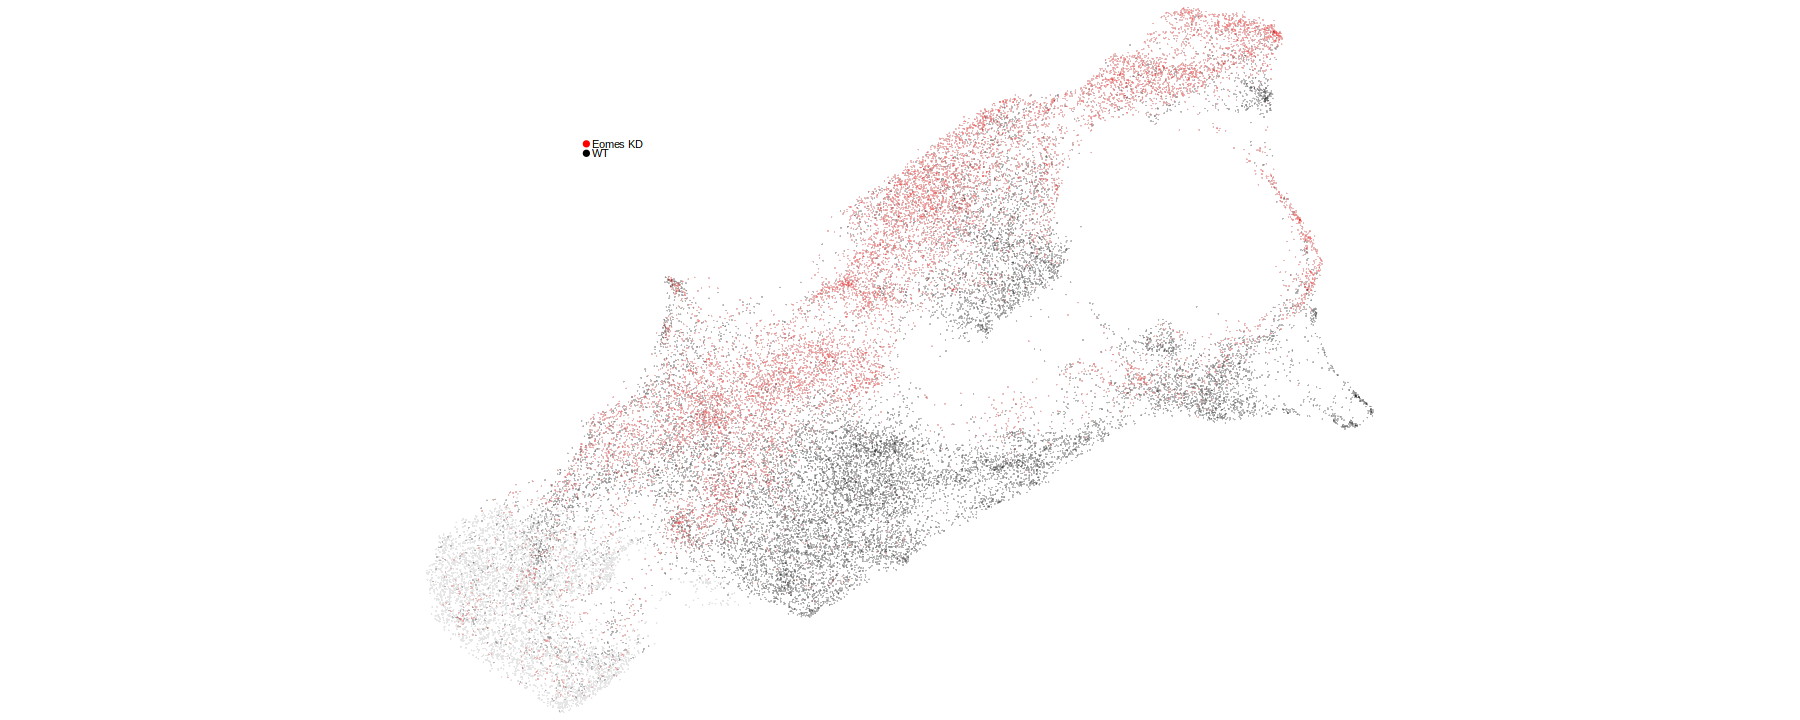

In [55]:
meta$genotype = gsub('KO', 'Eomes KD', meta$genotype)
opts$genotype.colors = c('WT' = 'black', 'Eomes KD' = 'red')

background_cells = fread(args$metadata)

p4 = ggplot(meta[sample(nrow(meta))], aes(UMAP1, UMAP2, color=genotype)) + 
    ggrastr::rasterise(geom_point(data = background_cells, size = -0.3, color='grey90'), dpi = 600) + 
    ggrastr::rasterise(geom_point(size = -0.3, alpha = 0.2), dpi = 900) + 
    scale_color_manual(values=opts$genotype.colors, guide = guide_legend(override.aes = list(size = 1, alpha = 1))) + 
 #   ggtitle('Condition') + 
    scale_x_continuous(expand=c(0.01,0.01)) + 
    scale_y_continuous(expand=c(0.01,0.01)) + 
    coord_fixed() + 
    theme_void() + 
    theme(legend.position = c(0.2, 0.8),
          legend.text = element_text(size = 6, margin = margin(l = -5)),
          legend.title = element_blank(),
          legend.key.size = unit(2, "mm"),
  #        plot.title = element_text(size=8, hjust=0.5, vjust=0, face='plain')
)
p4

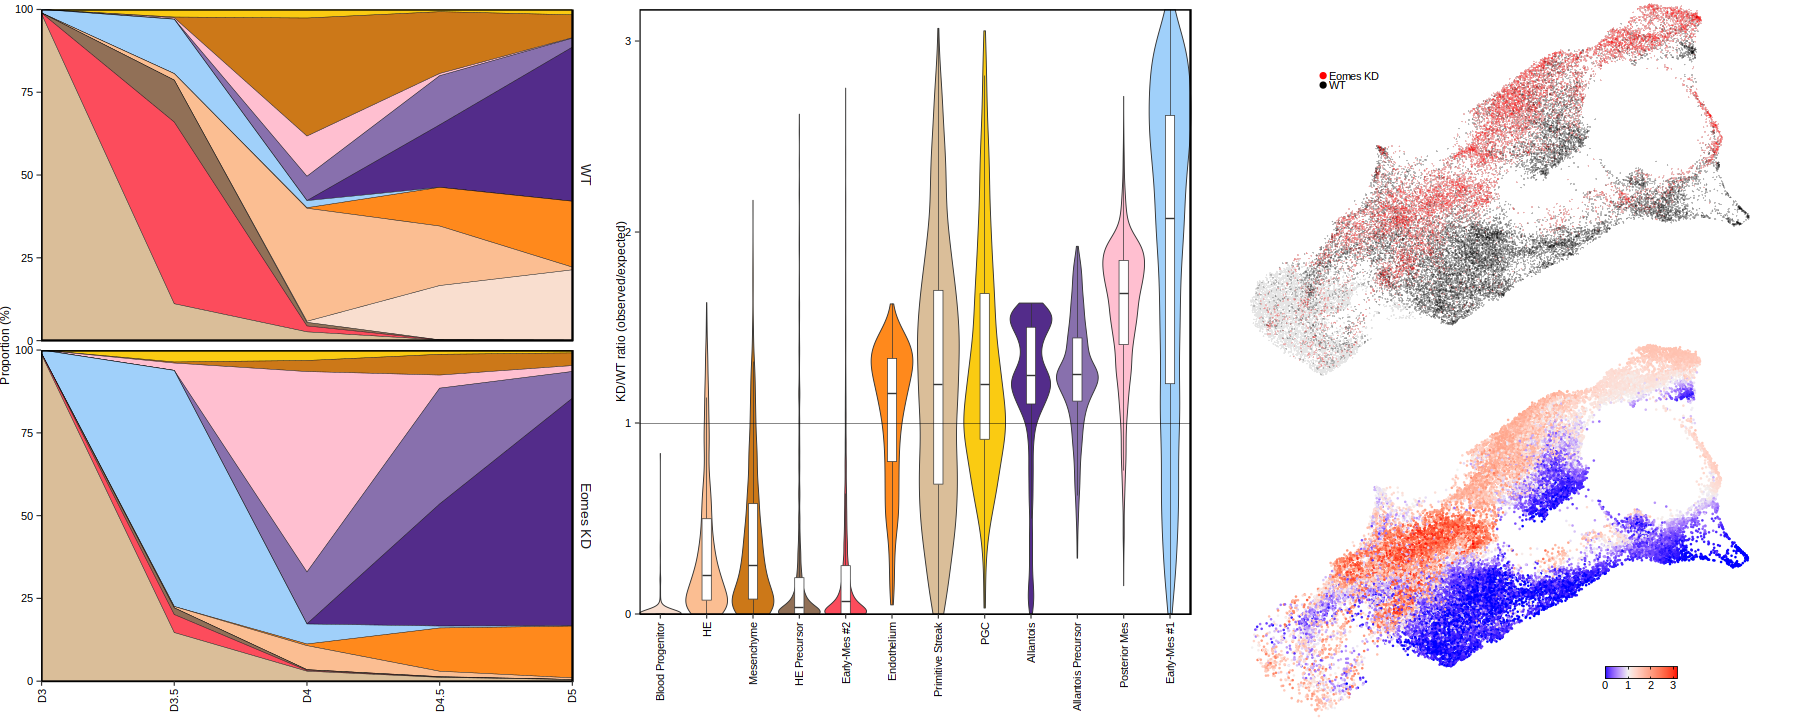

In [56]:
options(repr.plot.width=15, repr.plot.height=6)

ggarrange(p+theme(legend.position = 'none'), p2, ggarrange(p4, NULL, p3, ncol = 1, heights = c(1,-0.1, 1)), nrow = 1)

In [57]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_abundance_combined.pdf'), 
       plot = ggarrange(p+theme(legend.position = 'none'), p2, ggarrange(p4, NULL, p3, ncol = 1, heights = c(1,-0.1, 1)), nrow = 1, widths = c(1,1,0.7)),
       width = 150, 
       height = 55, 
       units = "mm")